## Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
X_train[:5, :]

array([[-0.09996055, -0.04464164, -0.02345095, -0.06419941, -0.05798303,
        -0.06018579,  0.01182372, -0.03949338, -0.01811827, -0.05078298],
       [-0.00914709, -0.04464164, -0.05686312, -0.05042793,  0.02182224,
         0.04534524, -0.02867429,  0.03430886, -0.00991896, -0.01764613],
       [ 0.01264814,  0.05068012, -0.07195249, -0.04698506, -0.05110326,
        -0.09713731,  0.11859122, -0.0763945 , -0.02028875, -0.03835666],
       [-0.02004471, -0.04464164, -0.0547075 , -0.0538708 , -0.06623874,
        -0.05736745,  0.01182372, -0.03949338, -0.07408887, -0.0052198 ],
       [-0.02730979, -0.04464164,  0.04768465, -0.04698506,  0.03420581,
         0.05724488, -0.08021722,  0.13025177,  0.04506617,  0.13146972]])

In [4]:
X_train.shape

(331, 10)

In [5]:
y_train[:5]

array([150., 183.,  77.,  42., 317.])

In [6]:
y_train.shape

(331,)

In [7]:
X_test.shape, y_test.shape

((111, 10), (111,))

In [8]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [10]:
def bias(y, z):
    return (y - z)

In [11]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## График зависимости ошибки от количества деревьев в ансамбле

In [12]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 5
eta = 0.1

In [13]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [14]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [15]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 288.85940705824976
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3391.626061217879


In [16]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')

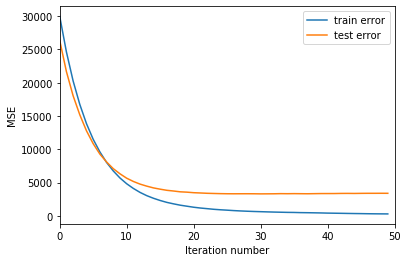

In [17]:
get_error_plot(n_trees, train_errors, test_errors)

#### После 20 итераций растет переобучение, а качество на тестовой выборке не меняется.

## График зависимости ошибки от максимальной глубины деревьев

In [18]:
%%time

n_trees = 30
coefs = [1] * n_trees
max_depth = 7
eta = 0.1
train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

Wall time: 1min 12s


In [19]:
def get_error_plot_(max_depth, train_err, test_err):
    plt.xlabel('Tree depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

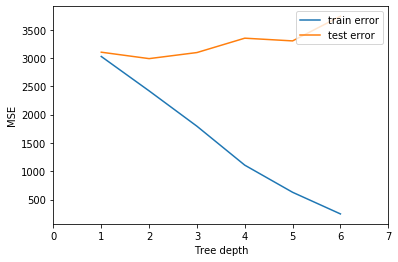

In [20]:
get_error_plot_(max_depth, train_errors_arr, test_errors_arr)

#### Ошибка на тренировочной выборке уменьшается при увеличении глубины дерева, но на тестовой выборке начинает расти после 3.

## Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

### Для стохастического градиентного бустинга изменим функцию "gb_fit"

In [21]:
%%time

def gb_st_fit(subsample_value, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # для реализации стохастического градиентного бустинга
        # мы уменьшаем на каждой итерации ошибку только на одном объекте
        
        # генерируем случайную подвыборку
        qnt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qnt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors

Wall time: 0 ns


In [22]:
n_trees = 70
coefs = [1] * n_trees
max_depth = 5
eta = 0.1

In [23]:
trees, train_errors, test_errors = gb_st_fit(0.5, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 70 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 411.35451301909666
Ошибка алгоритма из 70 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3359.3629191697055


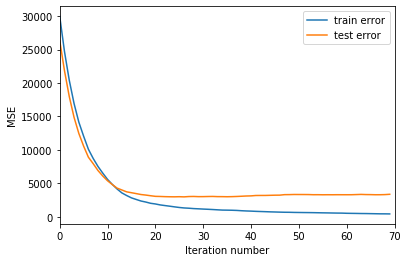

In [25]:
get_error_plot(n_trees, train_errors, test_errors)